# Find Slope Break

### Import dependencies
* ***src.TrackProfileUtil*** - utility for developing track parameters (gline int, dist, etc.)
* ***src.SlopeBreak2*** - calculates the exact slope break

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak2 as slpbr
pd.options.mode.chained_assignment = None

/tmp/ipykernel_609/1193224427.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Define bounds, granule, cycle & beam.
Then import track

In [2]:
rgt, name, cycle = 635, "gt2l", 5 # RGT and name information
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

In [3]:
fullpath = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
track = gpd.read_file(fullpath)

### Visualize raw flowslope vs. along track distance

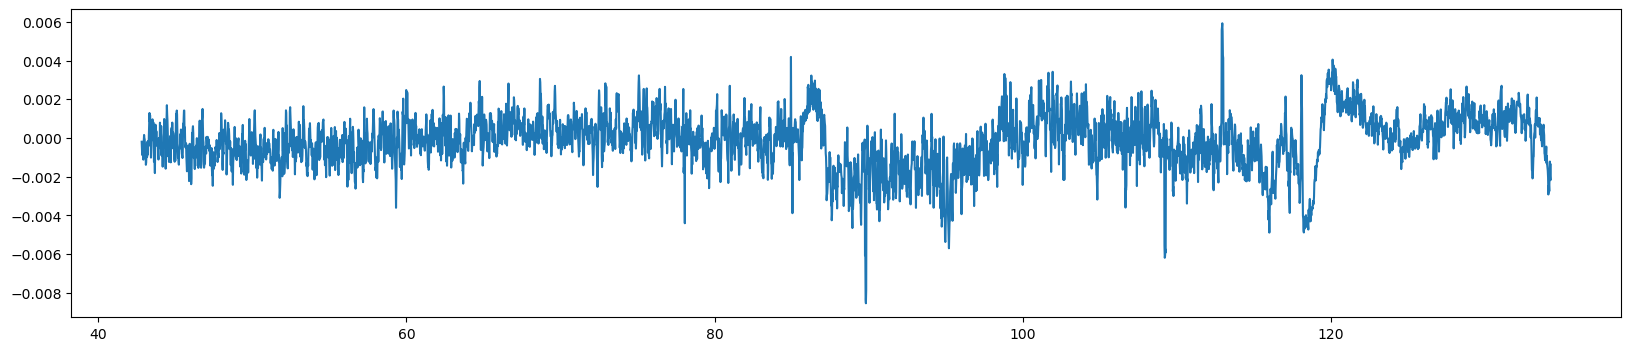

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_track_dist"], track["slope"])
plt.show()

### Import grounding line basemap

In [5]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

### Locate break in slope
Debug = **True** returns:<br>
* Intersection (x, y) EPSG:3031
* Along track dist @ intersection
* Average & 2nd standard deviation for the whole track.
* Parameters for each potential Ib pick including quality score (qs)
* If an ice plain was predicted in the track
* Reduced set of potential Ib's (Based on individual parameters)
* Final pick (Point in reduced set with highest quality score)

In [6]:
out = slpbr.findIb(track, gline_xy, debug=True)
boolib = False
try:
    track, ibs, qs, plain = out
    if type(ibs) != list and type(ibs) != np.ndarray:
        ibs = [ibs]
    boolib = True
except:
    track = out

Found intersection at: -848483.4521616799,391180.57427862793
Along track dist @ intersection 33.37185627457287
TRACK PARAMS FOR 635-gt2l-5:
avg: -0.00014810470790085412
2nd std dev: -0.002837574381781733 <-> 0.0025413649659800242
PICKS:
loc:10.92 slp:-0.0002 std:0.001522 rht:-0.002 lft:0.0004 r_s:0.001294 l_s:0.000527 qs:2.6626
loc:18.41 slp:-0.0024 std:0.000752 rht:-0.001 lft:-0.0017 r_s:0.001177 l_s:0.000797 qs:0.9273
loc:32.68 slp:-0.0001 std:0.000854 rht:-0.0006 lft:0.0002 r_s:0.001398 l_s:0.001161 qs:1.1062
loc:41.99 slp:-0.0026 std:0.001118 rht:0.0006 lft:-0.001 r_s:0.000508 l_s:0.001134 qs:1.1249
loc:9.7 slp:0.001 std:0.000846 rht:-0.0012 lft:0.0 r_s:0.001316 l_s:0.000537 qs:5.0878
loc:19.26 slp:-0.0025 std:0.000778 rht:-0.0005 lft:-0.0019 r_s:0.00119 l_s:0.000854 qs:1.6355
loc:42.96 slp:-0.0013 std:0.001964 rht:0.0013 lft:-0.0017 r_s:0.000515 l_s:0.001139 qs:1.0067
btwn 11.704547037184426 and 40.96227304101354 upper is 0.0016042128432729099 lower is -0.0029799964218063073
Ice p

### Visualize dist to grounding line
Distance from the grounding line is computed using a simple process to determine if the value should be negative or positive. Because of this there are often discontinuties in the data, (jump from + to - or vice versa) where the track does not actually cross the grounding line. This is an artifact of the algorithm and does not influence final outcomes.

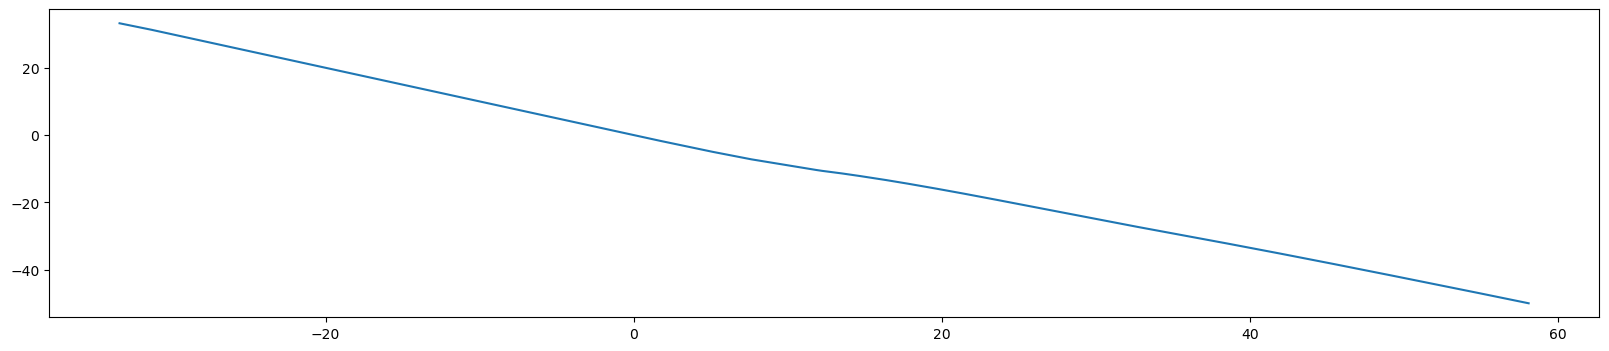

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["gline_dist"])
plt.show()

### Visualize elevation

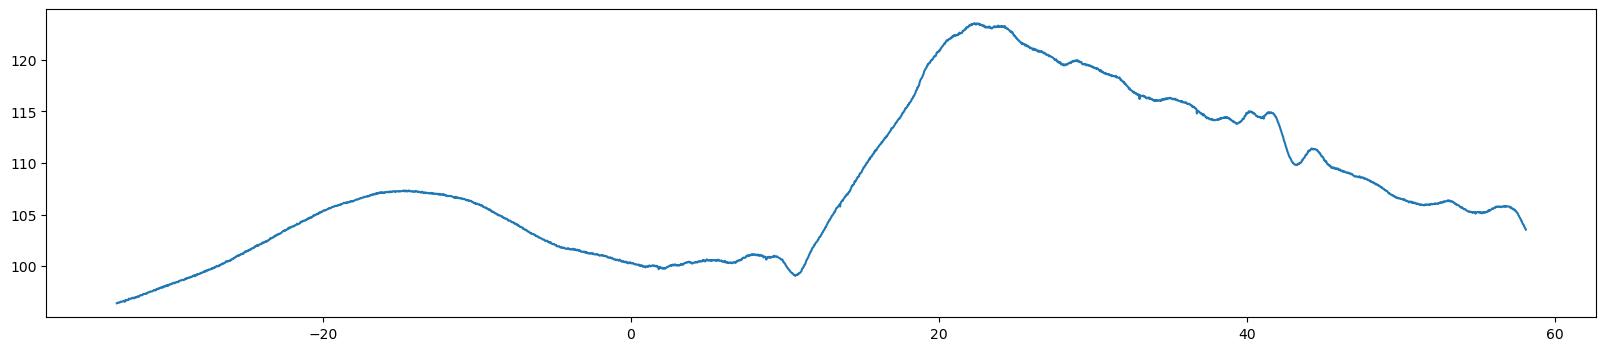

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["h_li"])
if boolib == True:
    for ib in ibs:
        ax.vlines(ib, 80, 120)
    if plain:
        ax.vlines(plain, 80, 120, linestyle="dashed", color="red")
plt.show()

### Visualize break in slope

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


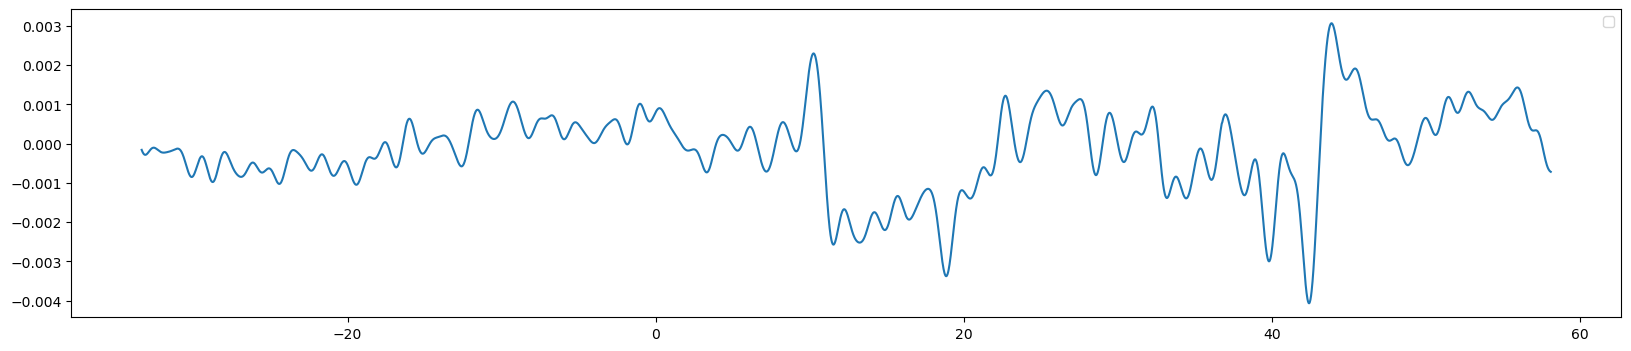

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["slope-filt"])
if boolib == True:
    for ib in ibs:
        ax.vlines(ib, -0.008, 0.004, label = "Break in slope")
    if plain:
        ax.vlines(plain, -0.008, 0.004, linestyle="dashed", color="red", label="Ice plain bounds")
plt.legend()
plt.show()

### Find XY of intersection & plain

In [10]:
xys = []

for ib in ibs:
    nearest_id = slpbr.find_nearest(track["along_dist"], ib)
    xys.append((track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"]))
    print(f"Ib @ {xys[-1]}")
    
pxys = []
if plain:
    for p in plain:
        nearest_id = slpbr.find_nearest(track["along_dist"], p)
        pxys.append((track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"]))
        print(f"Plain @ {pxys[-1]}")
    pxys = np.array(pxys)

NameError: name 'ibs' is not defined

### Final visualization

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

x, y = np.array(track["x"]), np.array(track["y"])
ax.scatter(x, y, s=1, c = track["slope-filt"])
plt.text(x[0]+1e3,y[0], s=f"{rgt}-{name}")
plt.text(x[-1]-4e3,y[-1], s="end")

for xy in xys:
    ax.scatter(xy[0], xy[1], color="red", s = 3)
    
#plot plain
if len(pxys) > 0:
    ax.plot(pxys[:, 0], pxys[:, 1], linestyle="dotted", color="red", alpha=0.8) 
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()